In [1]:
%%capture

import sys
naluhelperdir = '../../Postprocessing/utilities/'
sys.path.insert(1, naluhelperdir)

# Change some display properties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
import windspectra
import os.path
from matplotlib.lines import Line2D
%matplotlib inline


In [2]:
def findMatchingPt(ptlist, p, eps):
    for ipt, xpt in enumerate(ptlist):
        if (np.linalg.norm(np.array(xpt)-np.array(p)))<eps: return ipt
    # Error out
    
        
def avgSpectraLocations(ncdat, xvec, yvec, zvec, avgbins, verbose=True):
    """
    Average the spectra over multiple x, y, z locations
    """
    Nt     = ncdat.dimensions['num_time_steps'].size
    Npts   = ncdat['p_h'].dimensions['num_points'].size
    allpts = ncdat['p_h'].variables['coordinates']
    
    t      = ncdat['time'][:]
    allvx  = ncdat['p_h'].variables['velocityx']
    allvy  = ncdat['p_h'].variables['velocityy']
    allvz  = ncdat['p_h'].variables['velocityz']
    Navg   = 0
    all_ulongavgs = []
    for x in xvec:
        for y in yvec:
            for z in zvec:
                xyzpt = np.array([x,y,z])
                ipt   = findMatchingPt(allpts, xyzpt, 1.0E-6)
                print(allpts[ipt, :])
                u = allvx[:,ipt]
                v = allvy[:,ipt]
                w = allvz[:,ipt]
                ulong, ulat = windspectra.convertUxytoLongLat(u, v)
                all_ulongavgs.append(np.mean(ulong))
                f, Suu      = windspectra.avgWindSpectra(t, ulong, avgbins)
                f, Svv      = windspectra.avgWindSpectra(t, ulat,  avgbins)
                f, Sww      = windspectra.avgWindSpectra(t, w,     avgbins)
                if Navg == 0:
                    favg    = f
                    Suu_avg = Suu
                    Svv_avg = Svv
                    Sww_avg = Sww
                else:
                    Suu_avg = Suu_avg + Suu
                    Svv_avg = Svv_avg + Svv
                    Sww_avg = Sww_avg + Sww
                Navg  = Navg + 1
                #print(ipt)
    # Done looping over all points
    Suu_avg = Suu_avg/Navg
    Svv_avg = Svv_avg/Navg
    Sww_avg = Sww_avg/Navg
    if verbose: print("Averaged over %i planes"%Navg)
    return favg, Suu_avg, Svv_avg, Sww_avg, np.mean(all_ulongavgs)

In [3]:
# Load the sample plane netcdf data file
filename = '../../AMRWindRuns/stable/05ms/sim_dx2.5/post_processing/sampling60000.nc'
xpts     = [0, 100, 200]
ypts     = [0, 100, 200]
zpts     = [20]
avgbins  = []

ncdata   = Dataset(filename, 'r')


In [4]:
favg, Suu_avg, Svv_avg, Sww_avg, avgUlong = avgSpectraLocations(ncdata, xpts, ypts, zpts, avgbins)

[  0.   0.  20.]
[   0.  100.   20.]
[   0.  200.   20.]
[ 100.    0.   20.]
[ 100.  100.   20.]
[ 100.  200.   20.]
[ 200.    0.   20.]
[ 200.  100.   20.]
[ 200.  200.   20.]
Averaged over 9 planes


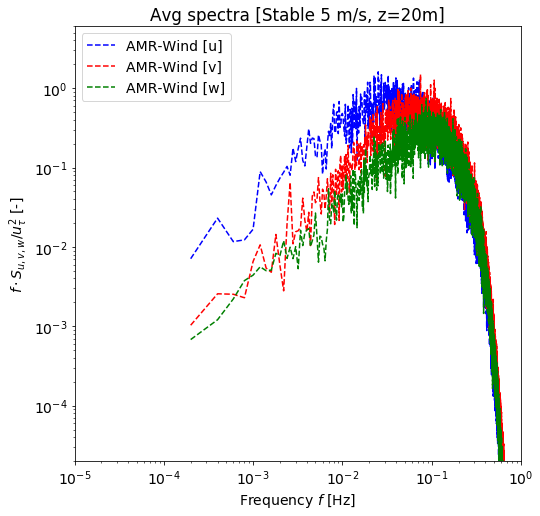

In [8]:
# Plot the longitudinal spectral
plt.figure(figsize=(8,8))
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14)
# Plot the Nalu Wind spectra
utau=0.145
f=favg
plt.loglog(f, f*Suu_avg/utau**2, 'b--', label='AMR-Wind [u]')
plt.loglog(f, f*Svv_avg/utau**2, 'r--', label='AMR-Wind [v]')
plt.loglog(f, f*Sww_avg/utau**2, 'g--', label='AMR-Wind [w]')

# Formatting options
plt.ylim([2E-5, 6]);
#plt.ylim([2E-2, 5]);
plt.xlim([1E-5, 1]);
plt.xlabel('Frequency $f$ [Hz]')
plt.ylabel('$f\cdot S_{u,v,w}/u_{\\tau}^2$ [-]')
plt.title('Avg spectra [Stable 5 m/s, z=%sm]'%'20')
plt.legend(loc='upper left')